Loading data...
Dataset shape: (4311, 17)

Selected features: ['duration', 'contact', 'housing', 'loan', 'previous', 'pdays']
Target variable: y

Preprocessing data...
Feature info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4311 entries, 0 to 4310
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   duration  4311 non-null   int64 
 1   contact   4311 non-null   object
 2   housing   4311 non-null   object
 3   loan      4311 non-null   object
 4   previous  4311 non-null   int64 
 5   pdays     4311 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 202.2+ KB
None

Target distribution:
y
no     3813
yes     498
Name: count, dtype: int64

Categorical features: ['contact', 'housing', 'loan']
Numerical features: ['duration', 'previous', 'pdays']
Encoded contact: ['cellular' 'telephone' 'unknown']
Encoded housing: ['no' 'yes']
Encoded loan: ['no' 'yes']
Target encoded: ['no' 'yes']

Splitting data...
Training set

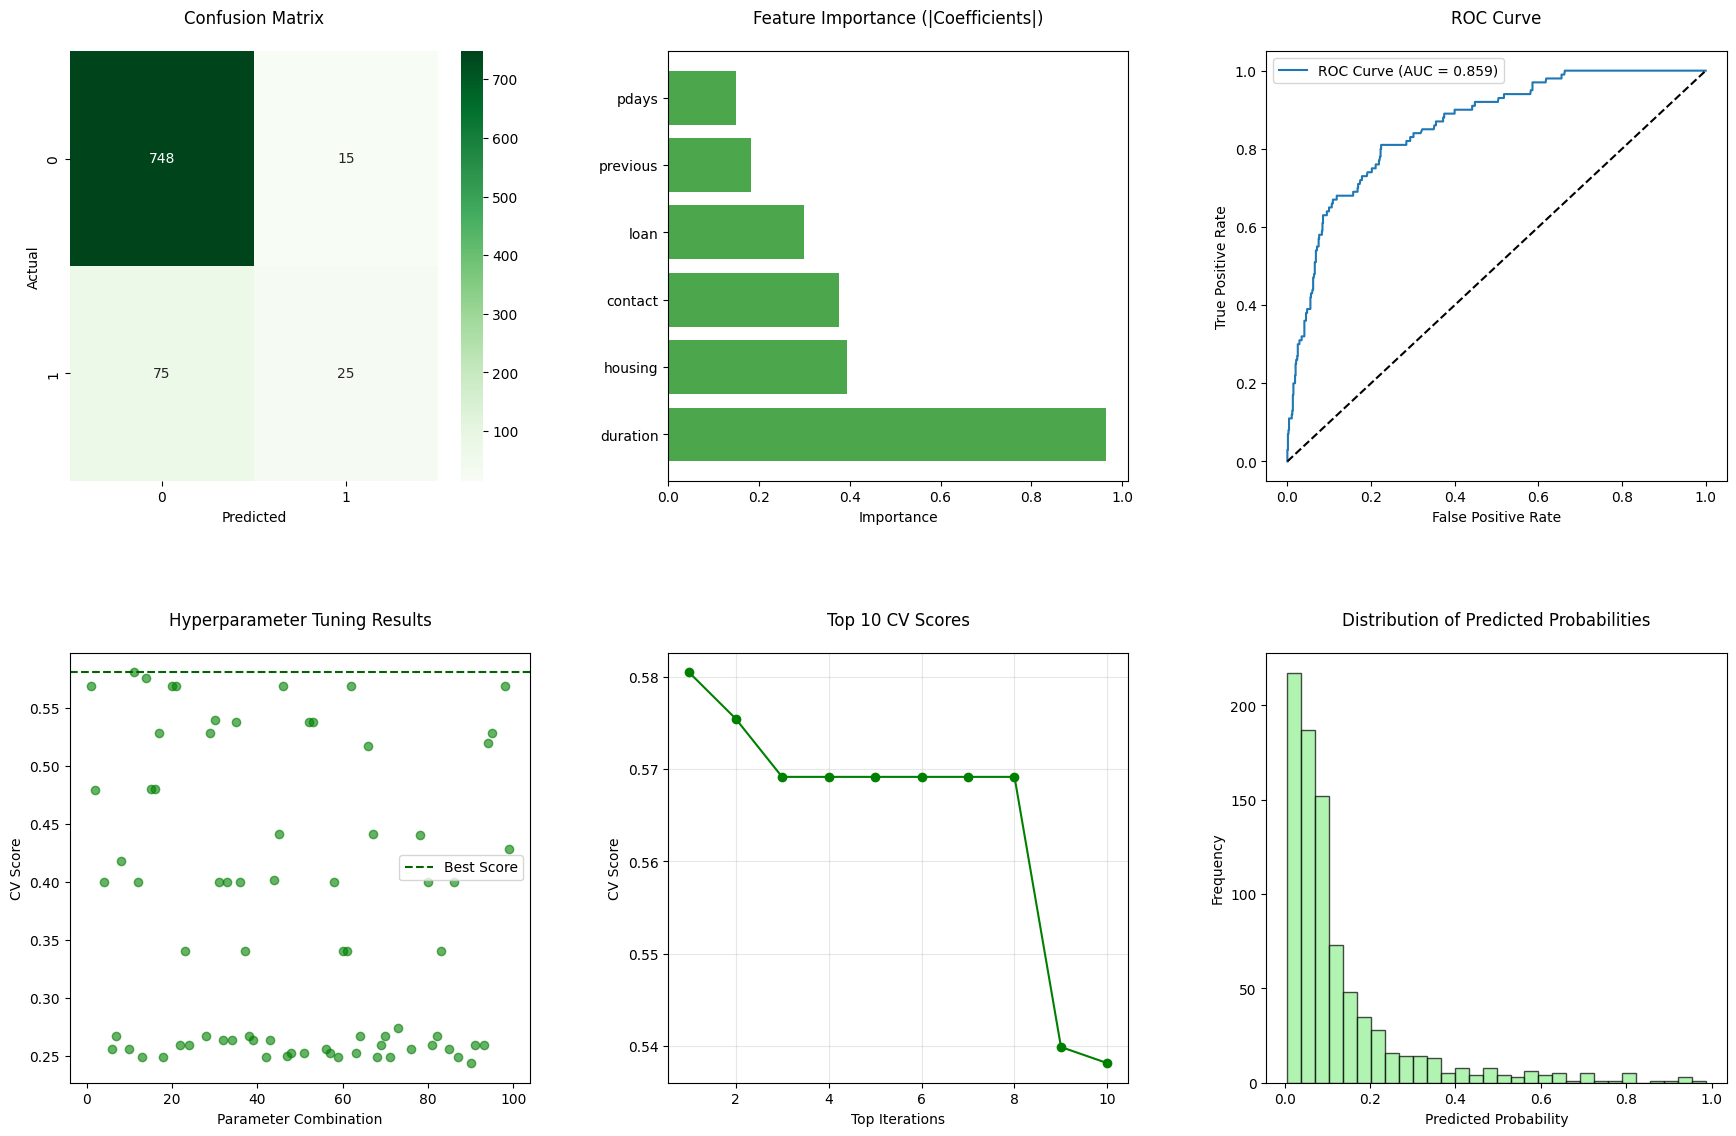


Cross-validation scores with best model:
CV Precision Scores: [0.39285714 0.61290323 0.64       0.625      0.63157895]
Mean CV Precision: 0.5805 (+/- 0.1884)

Saving the model...
Model saved as 'best_logistic_regression_model.pkl'
Label encoders saved as 'label_encoders.pkl'
Scaler saved as 'scaler.pkl'

FINAL SUMMARY
Best Model: Logistic Regression with automated hyperparameter tuning
Features used: 6 features
Training samples: 3448
Test samples: 863
Best CV Score: 0.5805
Test Accuracy: 0.8957
Test Precision: 0.6250
Test ROC-AUC: 0.8590
Most important feature: duration

Example prediction function created!
Use predict_new_data(best_model, label_encoders, scaler, your_data) to predict new samples


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("Loading data...")
df = pd.read_csv('bank_cleaned.csv')
print(f"Dataset shape: {df.shape}")

selected_features = ['duration', 'contact', 'housing', 'loan', 'previous', 'pdays']
target = 'y'

print(f"\nSelected features: {selected_features}")
print(f"Target variable: {target}")

missing_features = [col for col in selected_features + [target] if col not in df.columns]
if missing_features:
    print(f"Missing columns: {missing_features}")
    print(f"Available columns: {list(df.columns)}")
    exit()

print("\nPreprocessing data...")

X = df[selected_features].copy()
y = df[target].copy()

print("Feature info:")
print(X.info())
print(f"\nTarget distribution:")
print(y.value_counts())

categorical_features = []
numerical_features = []

for col in selected_features:
    if X[col].dtype == 'object':
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {le.classes_}")

if y.dtype == 'object':
    target_encoder = LabelEncoder()
    y = target_encoder.fit_transform(y)
    print(f"Target encoded: {target_encoder.classes_}")

print("\nSplitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training target distribution:\n{pd.Series(y_train).value_counts()}")

print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nSetting up enhanced hyperparameter tuning for better precision...")

param_distributions = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [500, 1000, 2000, 3000, 5000],
    'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}],
    'fit_intercept': [True, False],
    'intercept_scaling': [0.1, 0.5, 1, 2, 5, 10]
}

lr_model = LogisticRegression(
    random_state=42
)

print("Starting enhanced hyperparameter tuning (focusing on precision)...")
random_search = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=param_distributions,
    n_iter=100, 
    cv=5,      
    scoring='precision',  
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Training model with enhanced hyperparameter tuning (this may take a while)...")
random_search.fit(X_train_scaled, y_train)

print("\nEvaluating top models for best precision...")
cv_results = pd.DataFrame(random_search.cv_results_)
top_10_indices = cv_results.nlargest(10, 'mean_test_score').index

best_precision_score = 0
best_precision_model = None
best_precision_params = None

for idx in top_10_indices:
    params = cv_results.loc[idx, 'params']
    
    temp_model = LogisticRegression(random_state=42, **params)
    temp_model.fit(X_train_scaled, y_train)
    y_pred_temp = temp_model.predict(X_test_scaled)
    precision_temp = precision_score(y_test, y_pred_temp)
    
    if precision_temp > best_precision_score:
        best_precision_score = precision_temp
        best_precision_model = temp_model
        best_precision_params = params

if best_precision_model is not None:
    best_model = best_precision_model
    print(f"Found better precision model: {best_precision_score:.4f}")
else:
    best_model = random_search.best_estimator_

print("\nBest hyperparameters found:")
if best_precision_params:
    best_params = best_precision_params
else:
    best_params = random_search.best_params_

for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score: {random_search.best_score_:.4f}")
if best_precision_model:
    print(f"Best precision score on test: {best_precision_score:.4f}")

print("\nEvaluating model performance...")

y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nFeature Importance (Coefficients):")
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': np.abs(best_model.coef_[0])  # Use absolute values of coefficients
}).sort_values('importance', ascending=False)

print(feature_importance)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix', fontsize=12, pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 3, 2)
plt.barh(feature_importance['feature'], feature_importance['importance'], color='green', alpha=0.7)
plt.title('Feature Importance (|Coefficients|)', fontsize=12, pad=20)
plt.xlabel('Importance')

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.subplot(2, 3, 3)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=12, pad=20)
plt.legend()

plt.subplot(2, 3, 4)
cv_results = pd.DataFrame(random_search.cv_results_)
plt.scatter(range(len(cv_results)), cv_results['mean_test_score'], alpha=0.6, color='green')
plt.xlabel('Parameter Combination')
plt.ylabel('CV Score')
plt.title('Hyperparameter Tuning Results', fontsize=12, pad=20)
plt.axhline(y=random_search.best_score_, color='darkgreen', linestyle='--', label='Best Score')
plt.legend()

plt.subplot(2, 3, 5)
top_scores = cv_results.nlargest(10, 'mean_test_score')['mean_test_score'].values
plt.plot(range(1, 11), top_scores, 'go-', color='green')
plt.xlabel('Top Iterations')
plt.ylabel('CV Score')
plt.title('Top 10 CV Scores', fontsize=12, pad=20)
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
plt.hist(y_pred_proba, bins=30, alpha=0.7, edgecolor='black', color='lightgreen')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities', fontsize=12, pad=20)

plt.tight_layout(pad=3.0)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

print("\nCross-validation scores with best model:")
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='precision')
print(f"CV Precision Scores: {cv_scores}")
print(f"Mean CV Precision: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\nSaving the model...")
import joblib
joblib.dump(best_model, 'best_logistic_regression_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Model saved as 'best_logistic_regression_model.pkl'")
print("Label encoders saved as 'label_encoders.pkl'")
print("Scaler saved as 'scaler.pkl'")

print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)
print(f"Best Model: Logistic Regression with automated hyperparameter tuning")
print(f"Features used: {len(selected_features)} features")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Best CV Score: {random_search.best_score_:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")
print(f"Most important feature: {feature_importance.iloc[0]['feature']}")
print("="*50)

def predict_new_data(model, encoders, scaler, new_data_dict):
   
    new_df = pd.DataFrame([new_data_dict])
    
    for col in encoders.keys():
        if col in new_df.columns:
            new_df[col] = encoders[col].transform(new_df[col])
    
    new_df_scaled = scaler.transform(new_df)
    
    prediction = model.predict(new_df_scaled)[0]
    probability = model.predict_proba(new_df_scaled)[0]
    
    return prediction, probability

print("\nExample prediction function created!")
print("Use predict_new_data(best_model, label_encoders, scaler, your_data) to predict new samples")